1. Installing and importing dependencies

In [ ]:
# Provides a stable environment for breakout
# !pip install stable-baselines[mpi]==2.8.0
# Download and install ROMs (makes Gymnasium run breakout)
# !pip install gymnasuim[all,accept-rom-license]
# !gdown -q http://www.atarimania.com/roms/Roms.rar
# !pip install -q unrar
# !mkdir ./roms_atari
# !unrar x Roms.rar ./roms_atari > /dev/null 2>&1
# !python -m atari_py.import_roms ./roms_atari > /dev/null 2>&1

In [ ]:
# !pip install gym
# !pip install tensorflow
# !pip install matplotlib
# !pip install gymnasium[atari]
# !pip install gymnasium[accept-rom-license]
# ---- !pip install opencv-python
# !pip install scipy
# ---- !pip install git+https://github.com/openai/baselines


2. Examining the Breakout environment

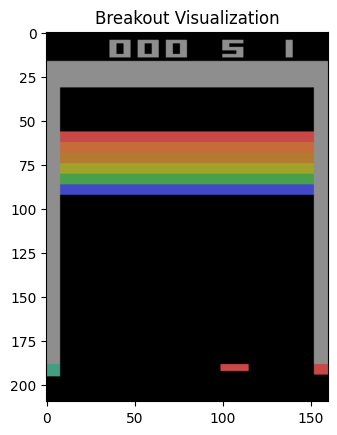

In [7]:
# from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import gymnasium
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random

env = gymnasium.make('ALE/Breakout-v5')
obs = env.reset()
# print(obs[0])
obs_arr = np.array(obs[0])
plt.imshow(obs_arr)
plt.title("Breakout Visualization")
plt.show()


# observation = env.reset()

In [34]:

import numpy as np
import gymnasium

env = gymnasium.make('ALE/Breakout-v5')
obs = env.reset()
rgb_array = np.array(env.reset()[0])
grayscale_array = np.mean(rgb_array, axis=-1, keepdims=True)
# Take an action in the environment
action = env.action_space.sample()  # Replace this with your desired action
# next_state, reward, done, info = env.step(action)
next_state = env.step(action)
next_arr = np.array(next_state[0])
arr = [grayscale_array, next_arr]
npy = np.array(arr)
# arr.append(grayscale_array)
# print(obs[0])
# obs_arr = np.array(obs[0])
# trimmed_array = arr[30:-16, 7:-7, :]
# print(trimmed_array.shape)
print(npy.shape)
# plt.imshow(next_state[0])
# plt.imshow(trimmed_array)
plt.imshow(npy)
plt.title("Breakout Visualization")
plt.show()


# observation = env.reset()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (2, 210, 160) + inhomogeneous part.

In [ ]:
from scipy.ndimage import zoom
from gymnasium.wrappers import RescaleAction
env = gymnasium.make('ALE/Breakout-v5')
wrapped_env = RescaleAction(env, min_action=0, max_action=1)
# env = gymnasium.make("BreakoutNoFrameskip-v4", env_id="ALE/Breakout-v5")
# env = wrap_deepmind(env, frame_stack=True, scale=True)
rgb_array = np.array(env.reset()[0])
# print(obs.shape)
grayscale_array = np.mean(rgb_array, axis=-1, keepdims=True)
# obs = rgb_array 
obs = grayscale_array
# TODO try and make the preprocessing by deleting the header and downsize the image to 84x84, (noralize brightness), stack 4 consecutave frames
# trimmed_array = grayscale_array[:, 7:-7, :]
print(env.observation_space.shape[0])
# obs = trimmed_array
print(obs.shape)

plt.title("Agent Observation (4 frames)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))
# plt.imshow(obs)
# resized_array = zoom(grayscale_array, zoom=(84/210, 84/160, 4), order=1)

# print(grayscale_array.shape)
# # obs = rgb_array 
# # obs = grayscale_array
# obs = resized_array 
# print(obs.shape)
# plt.subplot(1, 2, 2)
# # env = resized_array
# plt.title("Agent Observation (4 frames)")
# # plt.imshow(obs.transpose([0, 2, 1]).reshape([env.observation_space.shape[0], -1]))
# plt.imshow(resized_array[:, :, 0])

In [5]:
# Visualize the breakout environment
env = gymnasium.make('ALE/Breakout-v5', render_mode='human')
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

: 

In [91]:
height, width, channels = env.observation_space.shape
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT']

In [ ]:
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99 # Discount factor for past rewards
epsilon = 1.0 # Epsilon greedy parameter 
epsilon_min = 0.1 # Minimum epsilon greedy paramter
epsilon_max = 1.0 # Maximum epsilon greedy paramter

epsilon_interval = (
    epsilon_max - epsilon_min
) # Rate at which to reduce chance of random action being taken
batch_size = 32 # Size of batch taken from replay buffer
max_steps_per_episode = 10000

# env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(seed)

3. Creating a model - Deep convolutional neural network

In [112]:
num_actions = 4

def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(84, 84, 4,))

    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)

# The first model makes the predictions for Q-values which are used to make an action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()

4. Configuring the paramaters and model training

In [ ]:
# In the Deepmind paper they use RMSProp however then Adam optimizer which improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()

5. Evaluating and saving the model

In [ ]:
while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()

        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        # Apply the sampled action in our environment
        state_next, reward, done, _ = env.step(action)
        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 40:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

6. Making videos of our agent play